# First Part

In [58]:
#Start by importing all the packages I'm going to use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily as ctx
import geodatasets


# 1

In [27]:
#Import the dataset
#df = pd.read_csv("T:/ELS/W_Lisbeth/INF-PROF/Assignment/Chicago_Cimes_2008_to_2011.csv", sep=",", on_bad_lines='skip', low_memory=False)
df = pd.read_csv("https://raw.githubusercontent.com/lrnv/inf-prof/refs/heads/main/4_project/Chicago_Cimes_2008_to_2011.csv", sep=",", on_bad_lines='skip', low_memory=False)
df.head()

# Show the first 5 and last 5 rows
head_and_tail = pd.concat([df.iloc[:5], df.iloc[-5:]])
print(head_and_tail)

#Give the type object for each column.
print(df.info())

#Display the number of rows and columns
rows, columns = df.shape
print(f"The dataset has {rows} rows and {columns} columns.")

        Unnamed: 0       ID Case.Number                    Date  \
0          1614394  6744641    HR162637  02/09/2009 03:50:00 PM   
1           238567  6380338    HP465037  07/21/2008 11:30:00 PM   
2          2397513  7981904    HT214218  03/21/2011 07:00:00 PM   
3           957963  7522917    HS326336  05/25/2010 08:35:00 PM   
4          1909918  7216247    HR631679  11/07/2009 06:02:00 PM   
268866     2605355  8303648    HT538183  10/11/2011 03:09:00 PM   
268867      141977  6226734    HP314115  05/03/2008 12:10:43 AM   
268868     1836515  7104315    HR513428  08/31/2009 08:19:00 PM   
268869     1744173  6963964    HR356489  06/03/2009 03:00:00 PM   
268870      857677  7366491    HS169090  02/16/2010 11:00:00 AM   

                         Block  IUCR            Primary.Type  \
0             007XX S WELLS ST  2825           OTHER OFFENSE   
1          043XX S ROCKWELL ST  0610                BURGLARY   
2             109XX S AVENUE G  1320         CRIMINAL DAMAGE   
3     

# 2

In [28]:
# Check if there are any missing values in the entire dataset
print(df.isnull().values.any())
# Display the total number of missing values per column
print(df.isnull().sum())
# Display the proportion of missing values per column
print(df.isnull().mean())

True
Unnamed: 0                 0
ID                         0
Case.Number                0
Date                       0
Block                      0
IUCR                       0
Primary.Type               0
Description                0
Location.Description      31
Arrest                     0
Domestic                   0
Beat                       1
District                   8
Ward                      10
Community.Area           132
FBI.Code                   1
X.Coordinate            2890
Y.Coordinate            2890
Year                       1
Updated.On                 1
Latitude                2890
Longitude               2890
Location                2890
dtype: int64
Unnamed: 0              0.000000
ID                      0.000000
Case.Number             0.000000
Date                    0.000000
Block                   0.000000
IUCR                    0.000000
Primary.Type            0.000000
Description             0.000000
Location.Description    0.000115
Arrest            

# 3

In [29]:
# Check for duplicated IDs
duplicated_rows = df.duplicated(subset=['ID'])

# Count the total number of duplicated rows
num_duplicated_rows = duplicated_rows.sum()
print(f"The dataset has {num_duplicated_rows} duplicates")

# Drop duplicated rows based on the ID column
df = df.drop_duplicates(subset=['ID'])

# Set ID as index
df.set_index('ID', inplace=True)

The dataset has 11358 duplicates


# 4

In [30]:
#Identify non-numeric index rows
#This line of code converts the index to numeric values; non-numeic values become NaN when errors= 'coerce'
#.isna() checks which values are NaN, resulting in a boolean array indicating whether each index is numeric or not
non_numeric_index = pd.to_numeric(df.index, errors='coerce').isna()
print(len(df))

#Filter the DataFrame to keep only numeric indices
df = df[~non_numeric_index]
print(len(df))

257513
257512


# 5

In [31]:
# Convert the date column with correct format
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %I:%M:%S %p')
# Create the new column 'incident_date' in dd-mm-yyyy format
df['calendar_date'] = df['Date'].dt.strftime('%d-%m-%Y')
# Create the new column 'incident_time_24h' in 24-hour hh:mm:ss format
df['time'] = df['Date'].dt.time

In [32]:
# Get the hour with the most homicides
df['IUCR'] = df['IUCR'].astype(str)
homicide_codes = ['0110', '0130', '0141', '0142']
# Extract the hour from the 'time' column (which contains datetime.time objects)
df['hour'] = df['time'].apply(lambda x: x.hour)
# Filter the DataFrame for rows where the IUCR code indicates a homicide
homicides_df = df[df['Primary.Type']=='HOMICIDE']
# Group by the 'hour' column and count the number of homicides per hour
homicides_by_hour = homicides_df.groupby('hour').size()
most_homicides_hour = homicides_by_hour.idxmax()
print(f"The hour with the most homicides is: {most_homicides_hour}:00")

The hour with the most homicides is: 21:00


In [33]:
# Finding the day of the week with the fewest thefts
# Add a column for the day of the week based on calendar_date
df['day_of_week'] = pd.to_datetime(df['calendar_date'], format='%d-%m-%Y').dt.day_name()
# Filter for thefts
thefts_df = df[df['Primary.Type']=='THEFT']
# Count thefts per day of the week
thefts_by_day = thefts_df['day_of_week'].value_counts()
# Find the day of the week with the lowest number of thefts
lowest_theft_day = thefts_by_day.idxmin()
lowest_theft_count = thefts_by_day.min()
print(f"The day of the week with the lowest number of thefts is: {lowest_theft_day} with {lowest_theft_count} thefts.")

The day of the week with the lowest number of thefts is: Sunday with 6655 thefts.


In [34]:
# Find the most common crime reported on Christmas Day (25th December) across all years
# Create a 'month_day' column to filter for December 25th
df['month_day'] = df['Date'].dt.strftime('%m-%d')  # Format month-day as MM-DD
# Filter for Christmas Day
christmas_crimes_df = df[df['month_day'] == '12-25']
# Count occurrences of each crime on Christmas Day
if not christmas_crimes_df.empty:
    most_common_crime = christmas_crimes_df['Primary.Type'].value_counts().idxmax()
    most_common_crime_count = christmas_crimes_df['Primary.Type'].value_counts().max()
    print(f"The most common crime reported on Christmas Day is : {most_common_crime}  with {most_common_crime_count} occurrences.")
else:
    print("No crimes reported on Christmas Day.")

The most common crime reported on Christmas Day is : BATTERY  with 84 occurrences.


# 6

In [35]:
# Detect locations involving AIRPORT and replace with 'AIRPORT'
df.loc[df['Location.Description'].str.contains('AIRPORT', case=False, na=False), 'Location.Description'] = 'AIRPORT'
#case false means ignore casing in the string and na=False means any NaN values in the Series will be treated as False for the purpose of the search

# 7

In [36]:
# Filter incidents for the year 2008 and create a copy
df_2008 = df[df['Date'].dt.year == 2008].copy()
# Drop rows with NaN in the District column otherwise you can't convert to integer
df_2008.dropna(subset=['District'], inplace=True)
# Convert District column to integers
df_2008['District_Number'] = df_2008['District'].astype(int)
# Count the number of incidents per district
incidents_per_district = df_2008['District_Number'].value_counts()

In [37]:
# Create dataframe with population data for Chicago Districts
district_population = pd.DataFrame({
    'District_Number': [i for i in range(1, 26)],
    'District_Name': ['Central', 'Wentworth', 'Grand Crossing', 'South Chicago', 'Calumet',
                      'Gresham', 'Englewood', 'Chicago Lawn', 'Deering', 'Ogden',
                      'Harrison', 'Monroe', 'Wood', 'Shakespeare', 'Austin',
                      'Jefferson Park', 'Albany Park', 'Near North', 'Belmont',
                      'Lincoln', 'Prairie', 'Morgan Park', 'Town Hall',
                      'Rogers Park', 'Grand Central'],
    'Population': [25613, 50957, 93384, 141422, 92729, 105360, 91600, 244470, 165457,
                   137120, 82392, 69677, 60517, 132459, 72736, 199898, 156859,
                   110995, 107516, 102512, 78111, 111545, 98391, 151435, 212535]
})

In [38]:
# Set the index to District_Name
district_population.set_index('District_Number', inplace=True)

# Merge the incident counts with the population data, it's important we use left join because there is actually a district
# number in the original dataset that actually doesn't exist in the list of districts (nr 31)
criminality_data = district_population.join(incidents_per_district.rename('Incident_Count'), how='left').fillna(0)

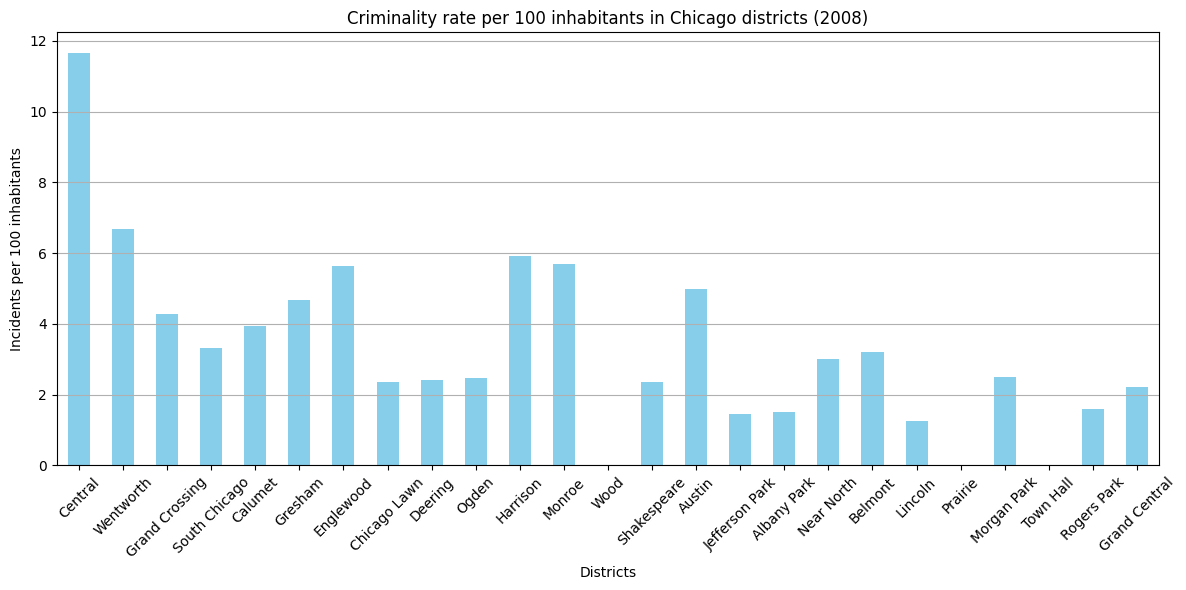

In [39]:
# Calculate the criminality rate
criminality_data['Criminality_Rate'] = (criminality_data['Incident_Count'] / criminality_data['Population']) * 100

# Create a bar plot for criminality rates
plt.figure(figsize=(12, 6))
criminality_data['Criminality_Rate'].plot(kind='bar', color='skyblue',
                                            xticks=range(len(criminality_data)),
                                            tick_label=criminality_data['District_Name'])
plt.title('Criminality rate per 100 inhabitants in Chicago districts (2008)')
plt.xlabel('Districts')
plt.ylabel('Incidents per 100 inhabitants')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 8

In [40]:
# Normalize the data by stripping whitespace and converting to lower case and then converting to boolean
df['Arrest'] = df['Arrest'].str.strip().str.lower()
df['Arrest'] = df['Arrest'].map({'true': True, 'false': False})

#Group by IUCR and count total incidents and arrests
arrests = df.groupby('Primary.Type').agg(
    Total_Incidents=('Primary.Type', 'size'),            # Count total incidents for each crime type
    Total_Arrests=('Arrest', 'sum')              # Count total arrests for each crime type
).reset_index()

#Calculate the proportion of arrests
arrests['Proportion_of_Arrests'] = arrests['Total_Arrests'] / arrests['Total_Incidents']*100
arrests=arrests.sort_values(by='Proportion_of_Arrests')
arrests['Proportion_of_Arrests'] = arrests['Proportion_of_Arrests'].round(2)

# Second Part

In [19]:
robberies=df[df['Primary.Type']=='ROBBERY']

In [48]:
#Group by District and count total incidents and arrests
arrests2 = robberies.groupby('District').agg(
    Total_Incidents=('District', 'size'),            # Count total incidents for each district
    Total_Arrests=('Arrest', 'sum')              # Count total arrests for each district
).reset_index()

#Calculate the proportion of arrests
arrests2['Proportion_of_Arrests'] = arrests2['Total_Arrests'] / arrests2['Total_Incidents']*100
arrest2s=arrests2.sort_values(by='Proportion_of_Arrests')
arrests2['Proportion_of_Arrests'] = arrests2['Proportion_of_Arrests'].round(2)

#Use the previous dataset with the population per district and join it with the arrest data
arrests2['District_Number'] = arrests2['District'].astype(int)
arrests2.set_index('District_Number', inplace=True)
heatmap_data = district_population.join(arrests2, how='left').fillna(0)
heatmap_data = heatmap_data[['District_Name', 'Proportion_of_Arrests']]

<Axes: xlabel='District_Number'>

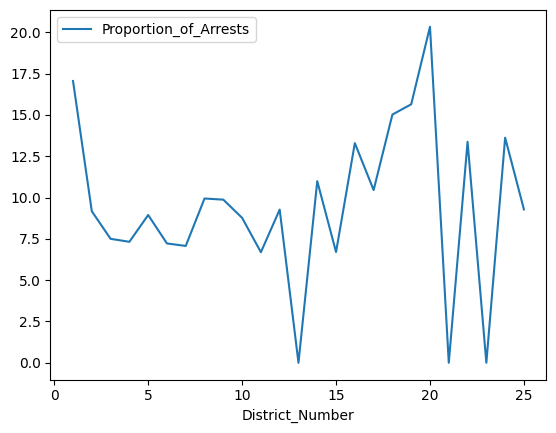

In [62]:
heatmap_data.plot()

In [59]:
chicago = geopandas.read_file(geodatasets.get_path("geoda.chicago_commpop"))
groceries = geopandas.read_file(geodatasets.get_path("geoda.groceries"))

Extracting 'chicago_commpop/chicago_commpop.geojson' from '/root/.cache/geodatasets/chicago_commpop.zip' to '/root/.cache/geodatasets/chicago_commpop.zip.unzip'
Extracting 'grocery/chicago_sup.shp' from '/root/.cache/geodatasets/grocery.zip' to '/root/.cache/geodatasets/grocery.zip.unzip'
Extracting 'grocery/chicago_sup.dbf' from '/root/.cache/geodatasets/grocery.zip' to '/root/.cache/geodatasets/grocery.zip.unzip'
Extracting 'grocery/chicago_sup.shx' from '/root/.cache/geodatasets/grocery.zip' to '/root/.cache/geodatasets/grocery.zip.unzip'
Extracting 'grocery/chicago_sup.prj' from '/root/.cache/geodatasets/grocery.zip' to '/root/.cache/geodatasets/grocery.zip.unzip'


,OBJECTID,Ycoord,Xcoord,Status,Address,Chain,Category,geometry
0,16,41.973266,-87.657073,OPEN,"1051 W ARGYLE ST, CHICAGO, IL. 60640",VIET HOA PLAZA,None,MULTIPOINT (1168268.672 1933554.35)
1,18,41.696367,-87.681315,OPEN,"10800 S WESTERN AVE, CHICAGO, IL. 60643-3226",COUNTY FAIR FOODS,None,MULTIPOINT (1162302.618 1832900.224)
2,22,41.868634,-87.638638,OPEN,"1101 S CANAL ST, CHICAGO, IL. 60607-4932",WHOLE FOODS MARKET,None,MULTIPOINT (1173317.042 1895425.426)
3,23,41.877590,-87.654953,OPEN,"1101 W JACKSON BLVD, CHICAGO, IL. 60607-2905",TARGET/SUPER,new,MULTIPOINT (1168996.475 1898801.406)
4,27,41.737696,-87.625795,OPEN,"112 W 87TH ST, CHICAGO, IL. 60620-1318",FOOD 4 LESS,None,MULTIPOINT (1176991.989 1847262.423)
...,...,...,...,...,...,...,...,...
143,585,41.880834,-87.647729,Chicago-West Loop,"40 S Halsted St, Chicago, IL 60661",Mariano's,None,MULTIPOINT (1171065.063 1899839.376)
144,586,41.920842,-87.669112,NewLocation,"2112 N Ashland Ave, Chicago IL 60614",Mariano's,None,MULTIPOINT (1165217.798 1914159.975)
145,587,41.835930,-87.664034,Chicago-Bridgeport,"3145 S Ashland Ave, Chicago, IL 60608",Mariano's,None,MULTIPOINT (1166186.713 1883581.309)
146,588,41.859370,-87.630062,Chicago-South Loop,"1615 S Clark St, Chicago, IL 60616",Mariano's,None,MULTIPOINT (1175778.816 1892214.445)


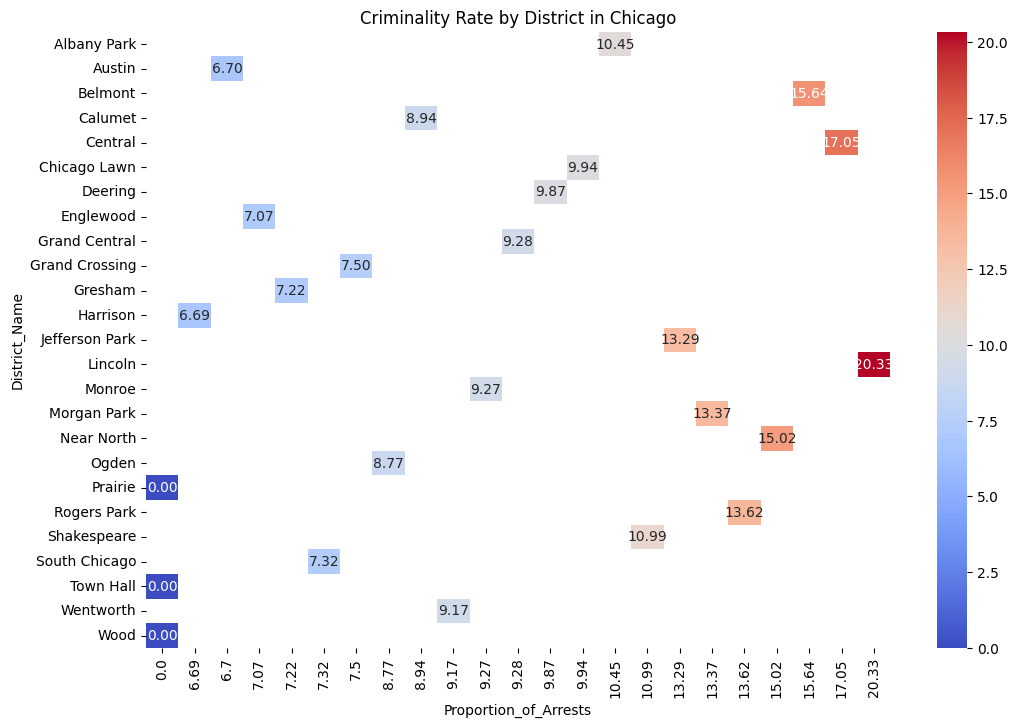

In [53]:
df_pivot = heatmap_data.pivot(index='District_Name', columns='Proportion_of_Arrests', values='Proportion_of_Arrests')

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_pivot, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Proportion of burglaries ending in arrests')
plt.show()